In [1]:
import os, cv2, json, random, itertools, rasterio, math, time, psutil, warnings
warnings.filterwarnings("ignore")

In [2]:
from tqdm import tqdm

In [3]:
from IPython.display import SVG

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
import seaborn as sns

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.metrics import confusion_matrix, f1_score

In [10]:
from sklearn.preprocessing import *

In [11]:
from tensorflow.keras.utils import plot_model, model_to_dot, to_categorical, Sequence

In [12]:
from tensorflow.keras.models import Sequential, Model, load_model

In [13]:
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense, Concatenate)

In [14]:
from tensorflow.keras.optimizers import Adam, SGD

In [15]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, LearningRateScheduler

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
from tensorflow.keras.initializers import *

In [18]:
from tensorflow.keras.regularizers import *

In [19]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [20]:
from tensorflow.keras.applications.resnet import ResNet50

In [21]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [22]:
with open("Dataset/label_map.json","r") as f:
    class_names_encoded = json.load(f)
    pass

class_names = list(class_names_encoded.keys())
num_classes = len(class_names)
class_names_encoded

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [23]:
bands = {'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'8a':9,'9':10,'10':11,'11':12,'12':13}

In [24]:
def Normalise(arr_band):
    
    return StandardScaler().fit_transform(arr_band)

In [25]:
basePath = "Dataset/"

def data_generator(csv_file, num_classes, batch_size = 10, target_size = 64):
    i = 0
    classes = set()
    df = pd.read_csv(csv_file)
    num_samples = df.shape[0]
    
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples_idx = df.index[offset:offset+batch_size]

            X, y = [], []

            for i in batch_samples_idx:
                img_name = df.loc[i,'Filename']
                label = df.loc[i,'Label']

                src = rasterio.open(os.path.join(basePath,img_name))

                arr_3, arr_4, arr_8 = src.read(bands['3']).astype(np.float32), src.read(bands['4']).astype(np.float32), src.read(bands['8']).astype(np.float32)
                arr_6, arr_7 = src.read(bands['6']).astype(np.float32), src.read(bands['7']).astype(np.float32)
                arr_11 = src.read(bands['11']).astype(np.float32)

                arr_3 = Normalise(arr_3)
                arr_4 = Normalise(arr_4)
                arr_6, arr_7 = Normalise(arr_6), Normalise(arr_7)
                arr_8 = Normalise(arr_8)
                arr_11 = Normalise(arr_11)

                bands_10_20 = np.dstack((arr_3, arr_4, arr_6, arr_7, arr_8, arr_11))

                X.append(bands_10_20)
                y.append(label)
                pass

            X = np.array(X)
            y = np.array(y)
            y = to_categorical(y, num_classes = num_classes)
            
            yield X, y
            pass
        pass
    pass


In [26]:
train_generator = data_generator(csv_file = "Dataset/train.csv", num_classes = 10, batch_size = 10)

In [27]:
val_generator = data_generator(csv_file = "Dataset/validation.csv", num_classes = 10, batch_size = 10)

In [28]:
train_df = pd.read_csv("Dataset/train.csv")

In [29]:
train_df.head()

,Filename,Label,ClassName
0,PermanentCrop/PermanentCrop_2401.tif,6,PermanentCrop
1,PermanentCrop/PermanentCrop_1006.tif,6,PermanentCrop
2,HerbaceousVegetation/HerbaceousVegetation_1025...,2,HerbaceousVegetation
3,SeaLake/SeaLake_1439.tif,9,SeaLake
4,River/River_1052.tif,8,River


In [30]:
_, train_labels_count = np.unique(train_df['Label'], return_counts=True)

train_count_df = pd.DataFrame(data = train_labels_count)
train_count_df['ClassName'] = class_names
train_count_df.columns = ['Count','ClassName']
train_count_df.set_index('ClassName', inplace=True)
train_count_df

,Count
ClassName,
AnnualCrop,2100
Forest,2100
HerbaceousVegetation,2100
Highway,1750
Industrial,1750
Pasture,1400
PermanentCrop,1750
Residential,2100
River,1750


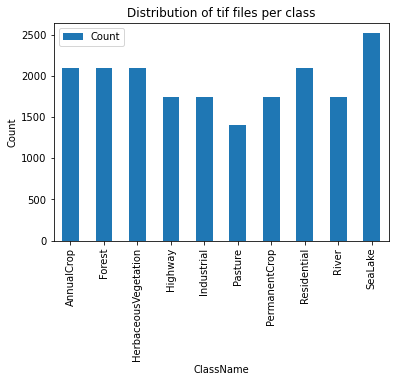

In [31]:
train_count_df.plot.bar()
plt.title("Distribution of tif files per class")
plt.ylabel("Count");

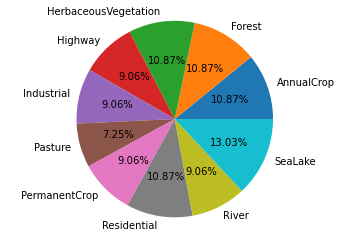

In [32]:
plt.pie(train_count_df.Count,
       explode = (0,0,0,0,0,0,0,0,0,0),
       labels = class_names,
       autopct="%1.2f%%")

plt.axis('equal');

In [33]:
train_labels = train_df.loc[:,'Label']

In [34]:
train_labels = np.array(train_labels)

In [35]:
num_train_samples = train_labels.shape[0]

In [36]:
val_df = pd.read_csv("Dataset/validation.csv")

In [37]:
val_df.head()

,Filename,Label,ClassName
0,Residential/Residential_1716.tif,7,Residential
1,Residential/Residential_735.tif,7,Residential
2,SeaLake/SeaLake_2384.tif,9,SeaLake
3,AnnualCrop/AnnualCrop_2534.tif,0,AnnualCrop
4,PermanentCrop/PermanentCrop_1363.tif,6,PermanentCrop


In [38]:
val_labels = val_df.loc[:,'Label']

In [39]:
val_labels = np.array(val_labels)

In [40]:
num_val_samples = val_labels.shape[0]

In [41]:
num_train_samples, num_val_samples

(19317, 5519)

In [42]:
def spectral_block(X,filters,stage,s=1):
    
    squeeze_base_name = 'squeeze_' + str(stage) + '_branch'
    bn_base_name = 'bn_' + str(stage) + "_branch"
    
    F1,F2,F3 = filters
    
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'a')(X)
    
    X_11 = Conv2D(filters=F2, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'b')(X)
    X_33 = Conv2D(filters=F3, kernel_size=(3,3), strides=(s,s), padding='same', name=squeeze_base_name+'c')(X)
    
    X = Concatenate(name="concatenate_"+str(stage))([X_11, X_33])
    X = BatchNormalization(name=bn_base_name)(X)
    
    X = Activation("relu", name="spectral"+str(stage))(X)
    
    return X
    pass

In [43]:
def deep_optimized_learning_model(input_shape, classes):
    
    X_input = Input(input_shape, name="input")
    
    X = Conv2D(96, (1,1), strides=(2,2), name='conv1', padding="same")(X_input)
    
    X = spectral_block(X, [16,96,32], 2)
    X = spectral_block(X, [16,96,32], 3)
    X = spectral_block(X, [32,192,64], 4)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool4")(X)
    
    X = spectral_block(X, [32,192,64], 5)
    X = spectral_block(X, [48, 288, 96], 6)
    X = spectral_block(X, [48, 288, 96], 7)
    X = spectral_block(X, [64, 384, 128], 8)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool8")(X)
    
    X = spectral_block(X, [64,384,128], 9)
    
    X = Conv2D(10, kernel_size=(1,1), strides=(1,1), name="conv10", padding='same')(X)
    X = BatchNormalization(name="conv10_batchnormalisation")(X)
    X = Activation("relu", name="conv10_activation")(X)
    
    X = AveragePooling2D(pool_size=(8,8), strides=(1,1), name="avgpool10")(X)
    
    X = Flatten(name="flatten10")(X)

    X = Activation("softmax", name="output")(X)
    
    model = Model(inputs=X_input, outputs=X, name="SpectrumNet")
    
    return model

In [44]:
model = deep_optimized_learning_model(input_shape = (64,64,6), classes=num_classes)

In [45]:
model.summary()

Model: "SpectrumNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 96)   672         input[0][0]                      
__________________________________________________________________________________________________
squeeze_2_brancha (Conv2D)      (None, 32, 32, 16)   1552        conv1[0][0]                      
__________________________________________________________________________________________________
squeeze_2_branchb (Conv2D)      (None, 32, 32, 96)   1632        squeeze_2_brancha[0][0]          
________________________________________________________________________________________

In [46]:
plot_model(model, to_file="6bands_v5-4.png",show_shapes=True,show_layer_names=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [47]:
checkpoint = ModelCheckpoint("6bands_weights_v5-5_SC.h5py", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
logs = TensorBoard("6bands-logs-SC", histogram_freq=1)

In [48]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.10
    epochs_drop = 30.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

In [49]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [50]:
loss_history = LossHistory()

In [51]:
lrate = LearningRateScheduler(step_decay)

In [52]:
train_labels_encoded = to_categorical(train_labels,num_classes=10)

In [53]:
classTotals = train_labels_encoded.sum(axis=0)

In [54]:
classWeight = {}

In [55]:
for i in range(len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]
    pass

In [56]:
classWeight

{0: 1.1985714,
 1: 1.1985714,
 2: 1.1985714,
 3: 1.4382857,
 4: 1.4382857,
 5: 1.7978572,
 6: 1.4382857,
 7: 1.1985714,
 8: 1.4382857,
 9: 1.0}

In [57]:
opt = SGD(lr=1e-3, momentum=0.9, nesterov=True)

In [58]:
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [59]:
epochs = 30
batchSize = 100

In [60]:
history = model.fit(train_generator,
                   steps_per_epoch = num_train_samples//batchSize,
                   epochs = epochs,
                   verbose = 1,
                   validation_data = val_generator,
                   validation_steps = num_val_samples//batchSize,
                   callbacks = [checkpoint, lrate, loss_history],
                   class_weight = classWeight
                   )

Epoch 1/30
193/193 [==============================] - 26s 129ms/step - loss: 2.4213 - categorical_accuracy: 0.4927 - val_loss: 2.5294 - val_categorical_accuracy: 0.1655

Epoch 00001: val_categorical_accuracy improved from -inf to 0.16545, saving model to 6bands_weights_v5-5_SC.h5py
INFO:tensorflow:Assets written to: 6bands_weights_v5-5_SC.h5py\assets
Epoch 2/30
193/193 [==============================] - 35s 184ms/step - loss: 1.9944 - categorical_accuracy: 0.5907 - val_loss: 1.7009 - val_categorical_accuracy: 0.4218

Epoch 00002: val_categorical_accuracy improved from 0.16545 to 0.42182, saving model to 6bands_weights_v5-5_SC.h5py
INFO:tensorflow:Assets written to: 6bands_weights_v5-5_SC.h5py\assets
Epoch 3/30
193/193 [==============================] - 36s 185ms/step - loss: 1.7330 - categorical_accuracy: 0.6534 - val_loss: 1.0109 - val_categorical_accuracy: 0.6964

Epoch 00003: val_categorical_accuracy improved from 0.42182 to 0.69636, saving model to 6bands_weights_v5-5_SC.h5py
INFO:

In [61]:
def plot_learning_rate(loss_history):
    
    plt.style.use("ggplot")
    
    plt.plot(np.arange(0,len(loss_history.lr)), loss_history.lr)
    plt.show();
    pass

In [62]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], 'r-', label='Training Loss')
    ax[0].plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax[1].plot(history.history['categorical_accuracy'], 'r-', label='Training Accuracy')
    ax[1].plot(history.history['val_categorical_accuracy'], 'g-', label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass

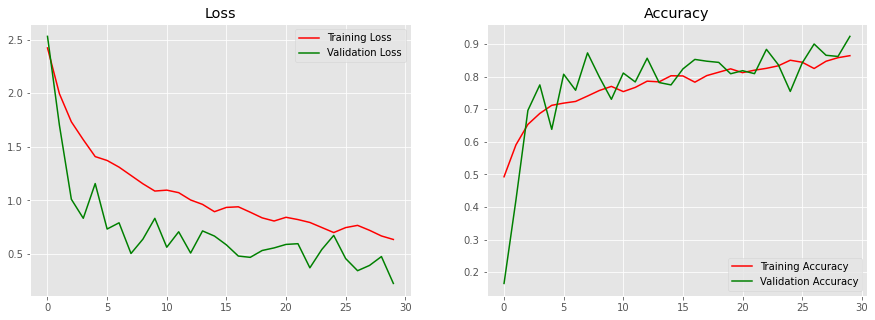

In [63]:
show_final_history(history)

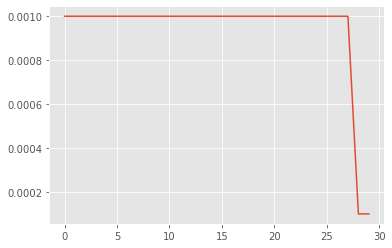

In [64]:
plot_learning_rate(loss_history)

In [65]:
def obtain_tif_images(csv_file):
    
    df = pd.read_csv(csv_file)
    num_samples = df.shape[0]
    
    X, y = [], []
    
    for i in tqdm(range(num_samples)):
        
        img_name = df.loc[i,'Filename']
        label = df.loc[i,'Label']

        src = rasterio.open(os.path.join(basePath,img_name))
        arr_3, arr_4, arr_8 = src.read(bands['3']), src.read(bands['4']), src.read(bands['8']) 
        arr_6, arr_7 = src.read(bands['6']), src.read(bands['7'])
        arr_11 = src.read(bands['11'])

        arr_3 = np.array(arr_3, dtype=np.float32)
        arr_4 = np.array(arr_4, dtype=np.float32)
        arr_6, arr_7 = np.array(arr_6, dtype=np.float32), np.array(arr_7, dtype=np.float32)
        arr_8 = np.array(arr_8, dtype=np.float32)
        arr_11 = np.array(arr_11, dtype=np.float32)

        arr_3 = Normalise(arr_3)
        arr_4 = Normalise(arr_4)
        arr_6, arr_7 = Normalise(arr_6), Normalise(arr_7)
        arr_8 = Normalise(arr_8)
        arr_11 = Normalise(arr_11)

        bands_10_20 = np.dstack((arr_3, arr_4, arr_6, arr_7, arr_8, arr_11))

        X.append(bands_10_20)
        y.append(label)
        
        pass
    
    X = np.array(X)
    y = np.array(y)
    
    return X,y
    pass

In [66]:
test_tifs, test_labels = obtain_tif_images(csv_file="Dataset/test.csv")

100%|█████████████████████████████████████████████████████████████████████████████| 2759/2759 [00:26<00:00, 105.66it/s]


In [67]:
test_labels_encoded = to_categorical(test_labels, num_classes = len(class_names))

In [68]:
test_tifs.shape, test_labels.shape, test_labels_encoded.shape

((2759, 64, 64, 6), (2759,), (2759, 10))

In [69]:
test_pred = model.predict(test_tifs)
test_pred = np.argmax(test_pred, axis=1)
test_pred.shape

(2759,)

In [70]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar();
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.0
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = 'center',
                color = "white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(False);
    pass

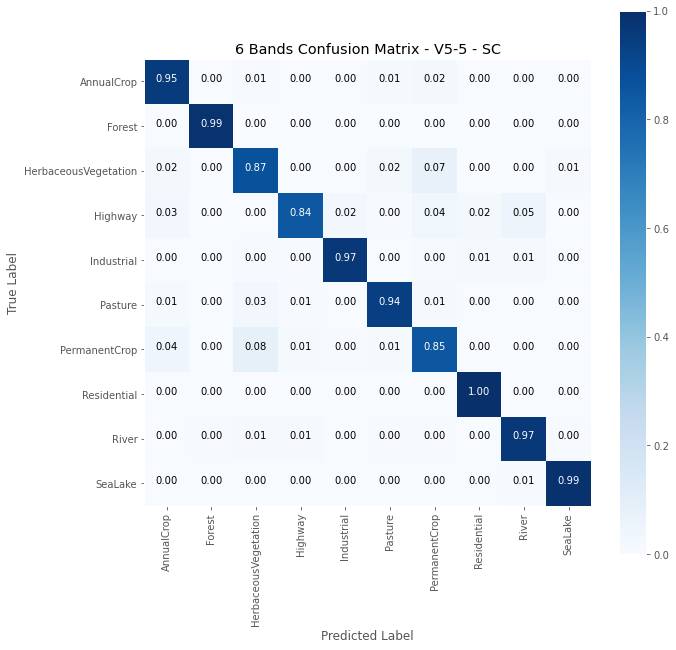

In [71]:
cnf_mat = confusion_matrix(test_labels, test_pred)

plot_confusion_matrix(cnf_mat, classes=class_names, title="6 Bands Confusion Matrix - V5-5 - SC")
plt.grid(False);

In [72]:
for f1,class_name in zip(f1_score(test_labels, test_pred, average=None), class_names):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass

Class name: AnnualCrop, F1 score: 0.935
Class name: Forest, F1 score: 0.987
Class name: HerbaceousVegetation, F1 score: 0.879
Class name: Highway, F1 score: 0.898
Class name: Industrial, F1 score: 0.970
Class name: Pasture, F1 score: 0.933
Class name: PermanentCrop, F1 score: 0.843
Class name: Residential, F1 score: 0.988
Class name: River, F1 score: 0.947
Class name: SeaLake, F1 score: 0.987


In [73]:
model.save("6bands_v5-5_SC.h5py")

INFO:tensorflow:Assets written to: 6bands_v5-5_SC.h5py\assets


In [74]:
model_test = load_model("./6bands_v5-5_SC.h5py")

model_test.summary()

Model: "SpectrumNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 96)   672         input[0][0]                      
__________________________________________________________________________________________________
squeeze_2_brancha (Conv2D)      (None, 32, 32, 16)   1552        conv1[0][0]                      
__________________________________________________________________________________________________
squeeze_2_branchb (Conv2D)      (None, 32, 32, 96)   1632        squeeze_2_brancha[0][0]          
________________________________________________________________________________________

In [75]:
model_test.load_weights("./6bands_weights_v5-5_SC.h5py")

In [76]:
test_pred_2 = model_test.predict(test_tifs)
test_pred_2 = np.argmax(test_pred_2, axis=1)
test_pred_2.shape

(2759,)

In [77]:
for f1,class_name in zip(f1_score(test_labels, test_pred_2, average=None), class_names):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass

Class name: AnnualCrop, F1 score: 0.935
Class name: Forest, F1 score: 0.987
Class name: HerbaceousVegetation, F1 score: 0.879
Class name: Highway, F1 score: 0.898
Class name: Industrial, F1 score: 0.970
Class name: Pasture, F1 score: 0.933
Class name: PermanentCrop, F1 score: 0.843
Class name: Residential, F1 score: 0.988
Class name: River, F1 score: 0.947
Class name: SeaLake, F1 score: 0.987


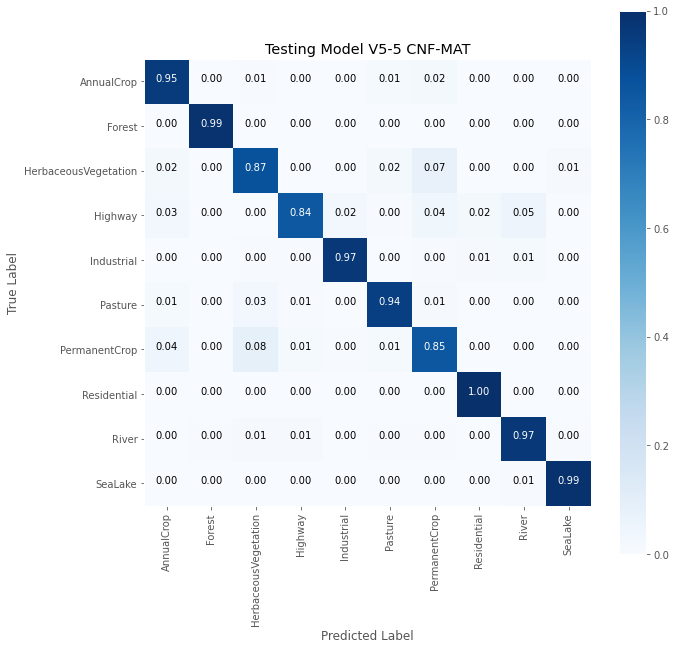

In [78]:
cnf_mat = confusion_matrix(test_labels, test_pred_2)

plot_confusion_matrix(cnf_mat, classes=class_names, title="Testing Model V5-5 CNF-MAT")
plt.grid(False)

In [79]:
val_tifs, val_labels = obtain_tif_images(csv_file="Dataset/validation.csv")

val_labels_encoded = to_categorical(val_labels, num_classes = len(class_names))

val_tifs.shape, val_labels.shape, val_labels_encoded.shape

100%|█████████████████████████████████████████████████████████████████████████████| 5519/5519 [00:23<00:00, 233.22it/s]


((5519, 64, 64, 6), (5519,), (5519, 10))

In [80]:
val_pred = model_test.predict(val_tifs)
val_pred = np.argmax(val_pred, axis=1)
val_pred.shape

(5519,)

In [81]:
for f1,class_name in zip(f1_score(val_labels, val_pred, average=None), class_names):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass

Class name: AnnualCrop, F1 score: 0.919
Class name: Forest, F1 score: 0.983
Class name: HerbaceousVegetation, F1 score: 0.885
Class name: Highway, F1 score: 0.878
Class name: Industrial, F1 score: 0.951
Class name: Pasture, F1 score: 0.934
Class name: PermanentCrop, F1 score: 0.841
Class name: Residential, F1 score: 0.967
Class name: River, F1 score: 0.953
Class name: SeaLake, F1 score: 0.988


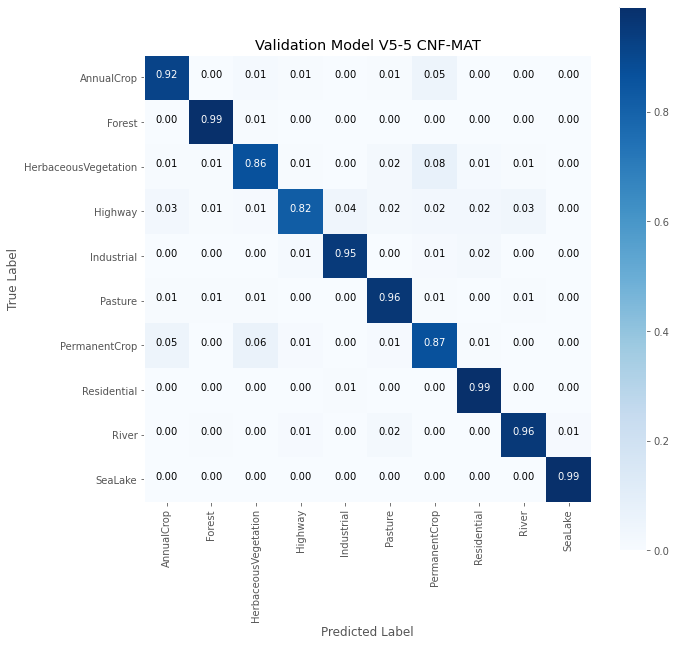

In [82]:
cnf_mat = confusion_matrix(val_labels, val_pred)

plot_confusion_matrix(cnf_mat, classes=class_names,title="Validation Model V5-5 CNF-MAT")
plt.grid(False)